In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#está dando errado se tentar pegar as imagens do path images
files_path = [os.path.abspath(x) for x in os.listdir("./images/img400x_recorte_horizontal") if x.endswith('.png')]
print(files_path)

In [ ]:
# diretorio, arquivo = path, filename = os.path.split(files_path[0])
# print(arquivo)
# img = cv2.imread(arquivo)
# plt.imshow(img)
# plt.show()
images = []
for i in files_path:
    diretorio, arquivo = path, filename = os.path.split(i)
    print(arquivo)
    img = cv2.imread(arquivo)
    images.append(img)
#     plt.imshow(img)
#     plt.show()
    


In [ ]:
# Demora muito tempo para imagens menores que 400x
stitcher = cv2.createStitcher()
status, stitched = stitcher.stitch(images)
print(status)

# Algoritmo stitcher do opencv

In [ ]:
cv2.imwrite("output.png", stitched)
plt.imshow(stitched)
plt.show()

# ORB keypoints

In [ ]:
# cv2.drawKeypoints está com erro em opencv 4.x, utilizar versão 3.4.5.20
a = []
kps1 = []
images = []

# disable OpenCL to because of bug in ORB in OpenCV 3.1
cv2.ocl.setUseOpenCL(False)

for i in files_path:
    diretorio, arquivo = path, filename = os.path.split(i)
    img = cv2.imread(arquivo)
    images.append(img)
    orb = cv2.ORB_create()
    

    
    keypoints, descriptors = orb.detectAndCompute(img, None)
    a.append(descriptors)
    kps1.append(keypoints)
    print(type(keypoints[0]))
#     img2 = cv2.drawKeypoints(img, keypoints, None, color=(0,255,0), flags=0)
    a.append(descriptors)
    kps1.append(keypoints)
#     a.append(descriptors)
#     img = cv2.drawKeypoints(img, keypoints, None)
#     print(type(descriptors))
    
#     plt.imshow(img2)
#     plt.show()



In [ ]:
## ORB

print('OpenCV version: {}'.format(cv2.__version__) )


## Load images
queryImg = cv2.imread('img400x_2.png')
trainImg = cv2.imread('img400x_1.png')

plt.show()
plt.imshow(queryImg)

plt.show()
plt.imshow(trainImg)

## Convert to gray
grayQuery = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)
grayTrain = cv2.cvtColor(trainImg, cv2.COLOR_BGR2GRAY)

## Creating orb detector
orb = cv2.ORB_create()
# orb = cv2.xfeatures2d.SIFT_create()


## Finding KPs and Descs
kpQuery, descQuery = orb.detectAndCompute(grayQuery, None)
kpTrain, descTrain = orb.detectAndCompute(grayTrain, None)

## Create Matcher
# matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matcher = cv2.BFMatcher()
print('Creating Brute Force matcher')

## Matching
# matches = matcher.match(descQuery, descTrain)
matches = matcher.knnMatch(descQuery, descTrain, k=2)

# Apply ratio test
good = []

for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)

matches = np.asarray(good)

# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kpQuery[match[0].queryIdx].pt
    points2[i, :] = kpTrain[match[0].trainIdx].pt
    
# Find homography
h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

print(h)



# Use homography
height, width, channels = trainImg.shape
im1Reg = cv2.warpPerspective(queryImg, h, (trainImg.shape[1] + queryImg.shape[1], trainImg.shape[0]) )

## Draw points
result = cv2.drawMatchesKnn(grayQuery, kpQuery, grayTrain, kpTrain,  matches[:10], None, (255,0,0), flags=2)

plt.show()
plt.imshow(result)
plt.show()


## Stitching
dst = cv2.warpPerspective(queryImg, h, (trainImg.shape[1] + queryImg.shape[1], trainImg.shape[0]) )
plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
plt.show()
plt.figure()

dst[0:trainImg.shape[0], 0:trainImg.shape[1]] = trainImg
cv2.imwrite('final.png',dst)
plt.imshow(dst)
plt.show()




# Código referente ao repositorio 

https://github.com/kushalvyas/Python-Multiple-Image-Stitching

['/app/img400x_1.png', '/app/img400x_2.png', '/app/img400x_3.png']


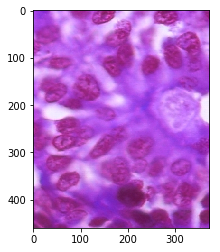

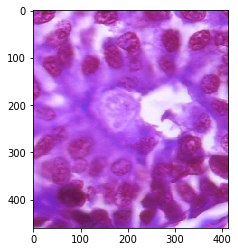

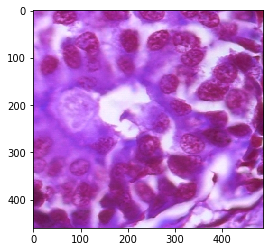

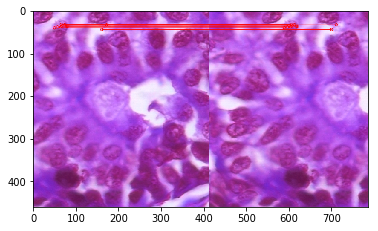

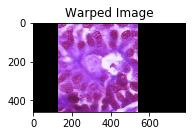

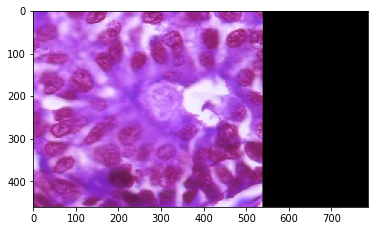

[[ 9.99955680e-01  1.61734690e-03  1.26099337e+02]
 [ 4.21455665e-05  1.00187624e+00 -3.23005880e-02]
 [ 1.26143486e-06  4.48011625e-06  1.00000000e+00]]
left


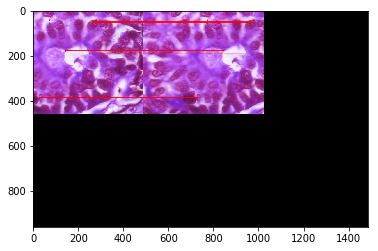

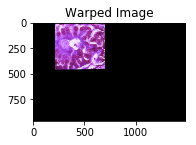

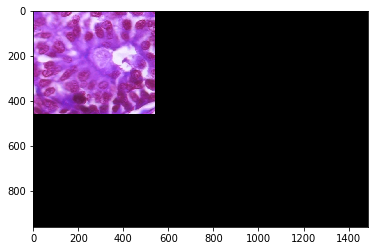

[[ 1.00038712e+00 -1.68136786e-03  2.13344630e+02]
 [ 1.83806533e-03  9.98911433e-01  6.88604200e-02]
 [ 7.29672980e-06 -4.97674842e-06  1.00000000e+00]]
right
stitching took 3.01 seconds.


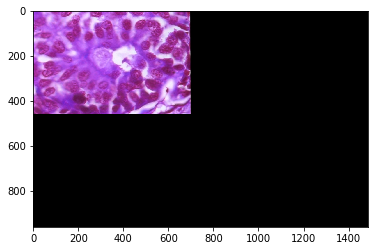

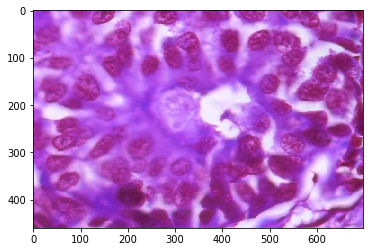

In [26]:
import timeit
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os


def checkBlack(pt):
    return pt[0] == 0 and pt[1] == 0 and pt[2] == 0

def blackBorder(image):
    
    w = None
    h = None
    
    for y in range(len(image)):
        if checkBlack(image[y][0]):
            h = y - 1
            break

    for x in range(len(image[0])):
        if checkBlack(image[0][x]):
            w = x - 1
            break
                
    return (w,h)

def imageWithoutFirstColBlack(img):

    w, h = blackBorder(img)
    if not w or not h:
        return img
    
    final_image = np.zeros((h, w, 3), dtype="uint8")

    for y in range(len(final_image)):
        for x in range(len(final_image[0])):
            final_image[y][x] = img[y][x]

    return final_image


class FeatureFinder():
    def __init__(self):
        self.matcher = None
        self.descriptor = None
        pass
    
    def getFeatures(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        print(self.descriptor)
        kp, des = self.descriptor.detectAndCompute(gray, None)
        return {"kp":kp, "des":des}
    
    def getMatches(self, img1, img2):
        return []
    
    def getHomography(self, good, img1, img2):
        return None


class SIFT(FeatureFinder):
    def __init__(self):
        FeatureFinder.__init__(self)
        self.descriptor = cv2.xfeatures2d.SIFT_create()
        self.matcher = cv2.BFMatcher()
        
    def getMatches(self, img1, img2):
        
        image_set_1 = self.getFeatures(img1)
        image_set_2 = self.getFeatures(img2)
        
        matches = self.matcher.knnMatch(image_set_2['des'], image_set_1['des'], k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])
                
        return good, image_set_1, image_set_2
    
    def getHomography(self, good, img1, img2):
        ## extract the matched keypoints
        src_pts  = np.float32([img1['kp'][m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts  = np.float32([img2['kp'][m.trainIdx].pt for m in good]).reshape(-1,1,2)

        ## find homography matrix and do perspective transform
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        return M

        
class SURF(FeatureFinder):
    def __init__(self):
        FeatureFinder.__init__(self)
        self.descriptor = cv2.xfeatures2d.SURF_create()
    
        index_params = dict(algorithm=0, trees=5)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)
        
    def getMatches(self, img1, img2):
        
        image_set_1 = self.getFeatures(img1)
        image_set_2 = self.getFeatures(img2)
        
        matches = self.flann.knnMatch(image_set_2["des"], image_set_1["des"], k=2)
        
        good = []
        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                good.append((m.trainIdx, m.queryIdx))
        
        return good, image_set_1, image_set_2
    
    def getHomography(self, good, image_set_1, image_set_2):
        
        if len(good) > 4:
            points_current = image_set_2["kp"]
            points_previous = image_set_1["kp"]

            matched_points_current = np.float32(
                [points_current[i].pt for (__, i) in good]
            )
            matched_points_prev = np.float32(
                [points_previous[i].pt for (i, __) in good]
            )

            H, _ = cv2.findHomography(
                matched_points_current, matched_points_prev, cv2.RANSAC, 4
            )
            return H
        return None
    


class ORB(FeatureFinder):
    def __init__(self):
        FeatureFinder.__init__(self)
        self.descriptor = cv2.ORB_create()
        self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        self.images = []
    
    def getFeatures(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        kp = self.descriptor.detect(gray,None)
        kp, des = self.descriptor.compute(gray, kp)
        
        return {"kp": kp, "des": des}
    
    def getMatches(self, img1, img2):
        image_set_1 = self.getFeatures(img1)
        image_set_2 = self.getFeatures(img2)
        
        self.images = [img1, img2]
        
        matches = self.matcher.match( image_set_2["des"], image_set_1["des"] )
        good = sorted(matches, key = lambda x:x.distance)
        
        return good, image_set_1, image_set_2
    
    def showPointAndStitch(self, queryImg, trainImg, H, kpQuery, kpTrain, matches):
        result = cv2.drawMatches(queryImg, kpQuery, trainImg, kpTrain,  matches[:10], None, (255,0,0), flags=2)

        plt.show()
        plt.imshow(result)
        plt.show()

        dst = cv2.warpPerspective(queryImg, H, (trainImg.shape[1] + queryImg.shape[1], trainImg.shape[0]) )
        plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
        plt.show()
        plt.figure()

        dst[0:trainImg.shape[0], 0:trainImg.shape[1]] = trainImg
        plt.imshow(dst)
        plt.show()
    
    def getHomography(self, good, img1, img2):
        ## extract the matched keypoints
        
        kp1 = img2['kp']
        kp2 = img1['kp']
        
        kps1 = [kp1[m.queryIdx].pt for m in good]
        kps2 = [kp2[m.trainIdx].pt for m in good]
        
        src_pts  = np.float32( kps1 ).reshape(-1,1,2)
        dst_pts  = np.float32( kps2 ).reshape(-1,1,2)

        ## find homography matrix and do perspective transform
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        img1, img2 = self.images[:2]

        self.showPointAndStitch(img2, img1, M, kp1, kp2, good)
        
        return M
        
        
        
        
        

class Matcher:
    def __init__(self, finder):
        self.featureFinder = finder

    def match(self, i1, i2):

        good, image_set_1, image_set_2 = self.featureFinder.getMatches(i1, i2)
    
        H = self.featureFinder.getHomography(good, image_set_1, image_set_2)
        
        return H

    def get_SURF_features(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, des = self.featureFinder.detectAndCompute(gray, None)
        return {"kp": kp, "des": des}


class Stitcher:
    def __init__(
        self,
        number_of_images,
        finder = SURF()
    ):

        self.matcher_obj = Matcher(finder)
        self.homography_cache = {}
        self.overlay_cache = {}

        self.count = number_of_images

    def stitch(self, images=[]):
        """
        stitches the images into a panorama
        """
        self.images = images

        self.prepare_lists()

        # left stitching
        start = timeit.default_timer()
        self.left_shift()
        self.right_shift()
        stop = timeit.default_timer()
        duration = stop - start
        print("stitching took %.2f seconds." % duration)

        return self.result

    def prepare_lists(self):

        # reset lists
        self.left_list = []
        self.right_list = []

        self.center_index = int(self.count / 2)

        self.result = self.images[self.center_index]

        for i in range(self.count):
            if i <= self.center_index:
                self.left_list.append(self.images[i])
            else:
                self.right_list.append(self.images[i])

    def get_homography(self, image_1, image_1_key, image_2, image_2_key, direction):
        # TODO: use image indexes from the input array
        """
        Calculate the homography matrix between two images.
        Return from cache if possible.
        Args:
            image_1 (np.array) - first image
            image_1_key (str) - identifier for cache
            image_2 (np.array) - second image
            image_2_key (str) - identifier for cache
            direction (str) - "left" or "right"
        Returns:
            homography (np.array) - Homograpy Matrix
        """

        cache_key = "_".join([image_1_key, image_2_key, direction])
        homography = self.homography_cache.get(cache_key, None)
        if homography is None:
            # TODO: is the homography the same regardless of order??
            homography = self.matcher_obj.match(image_1, image_2)
            print(homography)
            # put in cache
            self.homography_cache[cache_key] = homography
        return homography

    def left_shift(self):
        """
        stitch images center to left
        """
        # start off with center image
        a = self.left_list[0]

        for i, image in enumerate(self.left_list[1:]):
            H = self.get_homography(a, str(i), image, str(i + 1), "left")
            
            thresh = 500

            # inverse homography
            XH = np.linalg.inv(H)

            ds = np.dot(XH, np.array([a.shape[1], a.shape[0], 1]))
            ds = ds / ds[-1]

            f1 = np.dot(XH, np.array([0, 0, 1]))
            f1 = f1 / f1[-1]

            XH[0][-1] += abs(f1[0])
            XH[1][-1] += abs(f1[1])

            ds = np.dot(XH, np.array([a.shape[1], a.shape[0], 1]))
            offsety = abs(int(f1[1]))
            offsetx = abs(int(f1[0]))

            # dimension of warped image
            dsize = (int(round(ds[0]))+ offsetx + thresh, int(round(ds[1])) + offsety + thresh)
            
            tmp = cv2.warpPerspective(a, XH, dsize)
            
            # punch the image in there
            tmp[
                offsety : image.shape[0] + offsety, offsetx : image.shape[1] + offsetx
            ] = image

            a = tmp

            
        print('left')
        self.result = tmp

    def right_shift(self):
        """
        stitch images center to right
        """
        for i, imageRight in enumerate(self.right_list):
            imageLeft = self.result

            H = self.get_homography(imageLeft, str(i), imageRight, str(i + 1), "right")

            # args: original_image, matrix, output shape (width, height)
            result = cv2.warpPerspective(
                imageRight,
                H,
                (imageLeft.shape[1] + imageRight.shape[1], imageLeft.shape[0]),
            )

            mask = np.zeros((result.shape[0], result.shape[1], 3), dtype="uint8")
            mask[0 : imageLeft.shape[0], 0 : imageLeft.shape[1]] = imageLeft
            self.result = self.blend_images(mask, result, str(i))
        print('right')

    def blend_images(self, background, foreground, i):
        """
        inspired by this answer:
        https://stackoverflow.com/a/54129424/1909378
        """

        only_right = self.overlay_cache.get(i, None)
        if only_right is None:
            only_right = np.nonzero(
                (np.sum(foreground, 2) != 0) * (np.sum(background, 2) == 0)
            )
            self.overlay_cache[i] = only_right

        background[only_right] = foreground[only_right]
        return background


if __name__ == "__main__":
    
    path = "./images/img400x_7_recorte_horizontal/"
#     path = "./output/test-2/"
#     path = ""

    files_path = [os.path.abspath(x) for x in os.listdir(path) if x.endswith('.png')]
    files_path = sorted(files_path, key = lambda x:x)
        
    
    s = Stitcher( len(files_path), ORB() )
    
    print(files_path)
    
    images = [
        cv2.imread(f) for f in files_path
    ]
    
    for img in images:
        plt.imshow(img)
        plt.show()

    panorama = s.stitch(images)
    
    img = imageWithoutFirstColBlack(panorama)

    plt.imshow(panorama)
    plt.show()
    
    plt.imshow(img)
    plt.show()
    
    cv2.imwrite('output/out.png', img)